 - Dados 1: https://dados.gov.br/dados/conjuntos-dados/medicoes-de-campos-eletromagneticos1 (campos eletromagnéticos)
 - Dados 2: https://www.telecocare.com.br/mapaerbs/ (mapa de erbs do brasil - Anatel)

In [1]:
import pandas as pd
import numpy as np
import math as Math
import matplotlib.pyplot as plt
import datetime

from sklearn.cluster import KMeans

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [2]:
#read data from csv
df = pd.read_csv('Medicoes_de_Campos_Eletromagneticos_2016-2020.csv', sep = ';')
df.head(3)

<ipython-input-2-e292f12b20ab>:2: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Medicoes_de_Campos_Eletromagneticos_2016-2020.csv', sep = ';')


,Responsável,Nome Responsável,Data da Medicao,Hora da Medicao,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora da Estação
0,ANATEL,Agencia Nacional de Telecomunicacoes,01/01/2016,00:00:00,Fixas,"-30,046873","-51,206071",Porto Alegre,RS,"0,27","0,01%",N/I,NaN
1,ANATEL,Agencia Nacional de Telecomunicacoes,01/01/2016,00:00:00,Fixas,"-30,046873","-51,206071",Porto Alegre,RS,"0,4","0,02%",N/I,NaN
2,ANATEL,Agencia Nacional de Telecomunicacoes,01/01/2016,00:00:00,Fixas,"-27,59764","-48,54856",Florianópolis,SC,"0,48","0,03%",N/I,NaN


In [3]:
#handling dataframe column dtypes
df['Latitude'] = df['Latitude'].str.replace(',','.')
df['Longitude'] = df['Longitude'].str.replace(',','.')
df['Valor Medio'] = df['Valor Medio'].str.replace(',','.')
df['% do Limite'] = df['% do Limite'].str.replace(',','.')
df['% do Limite'] = df['% do Limite'].str.replace('%','')

#assigning new types for each column
df = df.astype({
    'Responsável': 'str', 
    'Nome Responsável': 'str',
    'Data da Medicao': 'str',
    'Hora da Medicao': 'str',
    'Tipo de Medicao': 'str',
    'Latitude': 'float32',
    'Longitude': 'float32',
    'Municipio': 'str',
    'UF': 'str',
    'Valor Medio': 'float32',
    '% do Limite': 'float32',
    'Número Estação': 'str',
    'Operadora da Estação': 'str',
})

#merging columns indicating date and time to make one Time column of tipe datetime
df.insert(3,'Time',df['Data da Medicao'] + ' ' + df['Hora da Medicao'])
df['Time'] = pd.to_datetime(df['Time'], format = '%d/%m/%Y %H:%M:%S')
df.drop(['Data da Medicao', 'Hora da Medicao'], axis = 1, inplace = True)

df.head()

,Responsável,Nome Responsável,Time,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora da Estação
0,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-30.046873,-51.206070,Porto Alegre,RS,0.27,0.01,N/I,nan
1,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-30.046873,-51.206070,Porto Alegre,RS,0.40,0.02,N/I,nan
2,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-27.597639,-48.548561,Florianópolis,SC,0.48,0.03,N/I,nan
3,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-25.435801,-49.283722,Curitiba,PR,1.76,0.40,N/I,nan
4,ANATEL,Agencia Nacional de Telecomunicacoes,2016-01-01,Fixas,-20.455133,-54.608875,Campo Grande,MS,0.22,0.01,N/I,nan


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642584 entries, 0 to 642583
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   Responsável           642584 non-null  object        
 1   Nome Responsável      642584 non-null  object        
 2   Time                  642584 non-null  datetime64[ns]
 3   Tipo de Medicao       642584 non-null  object        
 4   Latitude              642584 non-null  float32       
 5   Longitude             642584 non-null  float32       
 6   Municipio             642584 non-null  object        
 7   UF                    642584 non-null  object        
 8   Valor Medio           642584 non-null  float32       
 9   % do Limite           642584 non-null  float32       
 10  Número Estação        642584 non-null  object        
 11  Operadora da Estação  642584 non-null  object        
dtypes: datetime64[ns](1), float32(4), object(7)
memory usage: 

In [5]:
df.describe()

,Latitude,Longitude,Valor Medio,% do Limite
count,642584.000000,642584.000000,642584.000000,642584.000000
mean,-14.939528,-47.465439,0.725878,0.158150
std,8.406721,7.933362,0.844869,0.717122
min,-33.690331,-72.907440,0.010000,0.000000
25%,-20.455133,-52.257786,0.280000,0.010000
50%,-15.805153,-47.882725,0.470000,0.030000
75%,-8.761610,-42.800816,0.900000,0.100000
max,3.842410,-32.401241,27.959999,99.709999


In [6]:
#some basic information about the dataset
print(f'Total de empresas responsáveis: {len(df["Nome Responsável"].unique())}')
print(f'Tipos de medição: {len(df["Tipo de Medicao"].unique())}')
print(f'Total de Municípios Distintos: {len(df["Municipio"].unique())}')
print(f'Total de Unidades da Federação: {len(df["UF"].unique())}')

Total de empresas responsáveis: 11
Tipos de medição: 3
Total de Municípios Distintos: 4153
Total de Unidades da Federação: 27


In [7]:
df_anapolis = df[(df['UF'] == 'GO') & (df['Municipio'] == 'Anápolis')]

latmin_anapolis = min(df_anapolis['Latitude'])
latmax_anapolis = max(df_anapolis['Latitude'])
longmin_anapolis = min(df_anapolis['Longitude'])
longmax_anapolis = max(df_anapolis['Longitude'])

latmin_bra = min(df['Latitude'])
latmax_bra = max(df['Latitude'])
longmin_bra = min(df['Longitude'])
longmax_bra = max(df['Longitude'])

print(f'Brasil\nlatmin: {latmin_bra}\nlatmax: {latmax_bra}\nlongmin: {longmin_bra}\nlongmax: {longmax_bra}\n')
print(f'Anápolis\nlatmin: {latmin_anapolis}\nlatmax: {latmax_anapolis}\nlongmin: {longmin_anapolis}\nlongmax: {longmax_anapolis}\n')

Brasil
latmin: -33.690330505371094
latmax: 3.842410087585449
longmin: -72.90744018554688
longmax: -32.401241302490234

Anápolis
latmin: -16.41152000427246
latmax: -16.254030227661133
longmin: -48.99911117553711
longmax: -48.78670120239258



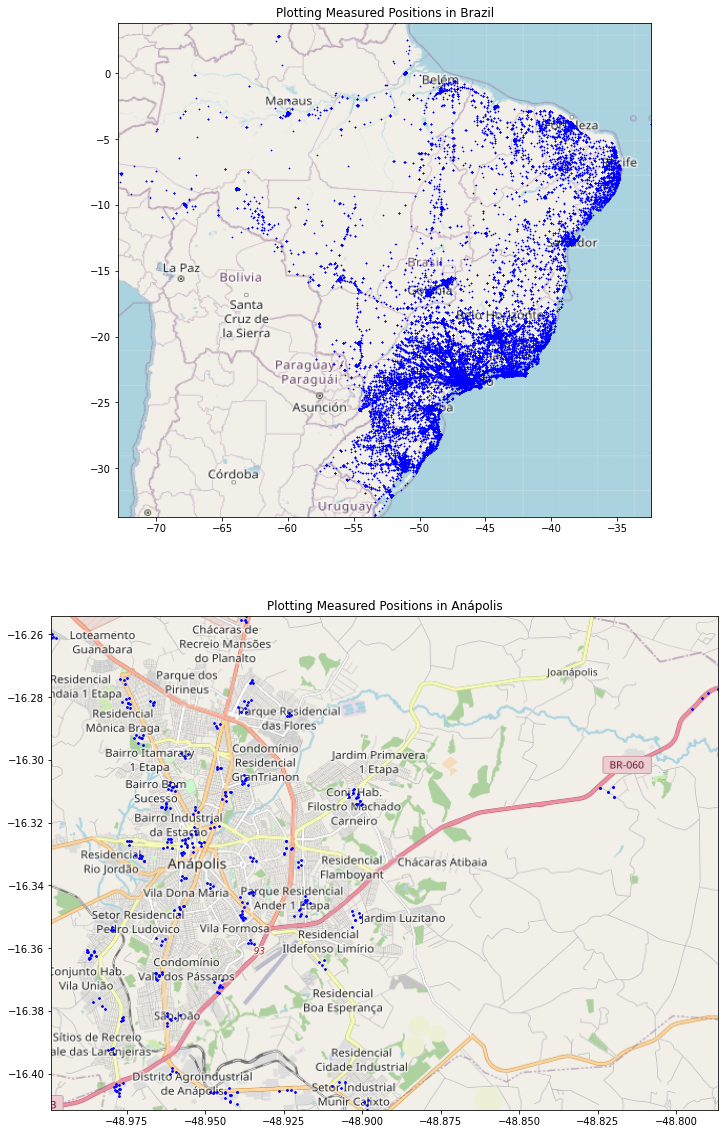

In [8]:
BBox_bra = ((longmin_bra, longmax_bra, latmin_bra, latmax_bra))
BBox_anapolis = ((longmin_anapolis, longmax_anapolis, latmin_anapolis, latmax_anapolis))

brasil = plt.imread('brasil.png')
anapolis = plt.imread('anapolis.png')

fig, axs = plt.subplots(2,1,figsize = (16,20))
axs[0].scatter(df.Longitude, df.Latitude, zorder=1, alpha= 1, c='b', s=0.1)
axs[0].set_title('Plotting Measured Positions in Brazil')
axs[0].set_xlim(BBox_bra[0],BBox_bra[1])
axs[0].set_ylim(BBox_bra[2],BBox_bra[3])
axs[0].imshow(brasil, zorder=0, extent = BBox_bra, aspect= 'equal')

axs[1].scatter(df_anapolis.Longitude, df_anapolis.Latitude, zorder=1, alpha= 1, c='b', s=3)
axs[1].set_title('Plotting Measured Positions in Anápolis')
axs[1].set_xlim(BBox_anapolis[0],BBox_anapolis[1])
axs[1].set_ylim(BBox_anapolis[2],BBox_anapolis[3])
axs[1].imshow(anapolis, zorder=0, extent = BBox_anapolis, aspect= 'equal')

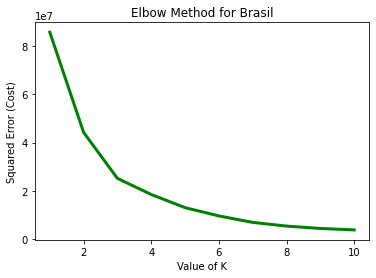

In [9]:
def elbow_method(X,title):
    cost =[]
    for i in range(1, 11):
        KM = KMeans(n_clusters = i, max_iter = 500)
        KM.fit(X)

        # calculates squared error
        # for the clustered points
        cost.append(KM.inertia_)    

    # plot the cost against K values
    plt.plot(range(1, 11), cost, color ='g', linewidth ='3')
    plt.title(title)
    plt.xlabel("Value of K")
    plt.ylabel("Squared Error (Cost)")
    plt.show() # clear the plot
    
elbow_method(df[['Latitude','Longitude']], 'Elbow Method for Brasil')

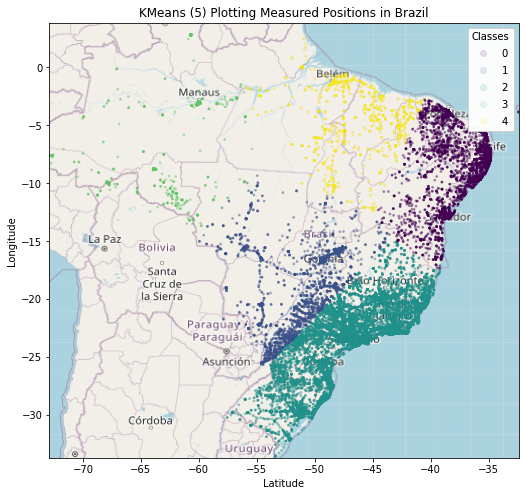

In [10]:
def plot_kmeans(k,df,xcol,ycol):
    #application of kmeans
    X = df[[xcol,ycol]]
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X)
    predictions = kmeans.predict(X)
    
    BBox_bra = ((longmin_bra, longmax_bra, latmin_bra, latmax_bra))
    brasil = plt.imread('brasil.png')
    
    fig, axs = plt.subplots(1,1,figsize = (16,8))
    scatter = axs.scatter(df.Longitude, df.Latitude, zorder=1, alpha= 0.1, c=predictions, s=3)
    axs.set_title(f'KMeans ({k}) Plotting Measured Positions in Brazil')
    axs.set_xlim(BBox_bra[0],BBox_bra[1])
    axs.set_ylim(BBox_bra[2],BBox_bra[3])
    legend1 = axs.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
    axs.add_artist(legend1)
    axs.set_xlabel(xcol)
    axs.set_ylabel(ycol)
    axs.imshow(brasil, zorder=0, extent = BBox_bra, aspect= 'equal')
    
plot_kmeans(5, df, 'Latitude', 'Longitude')

In [11]:
def getDistanceFromLatLonInKm(lat1,lon1,lat2,lon2):
    R = 6371;
    dLat = deg2rad(lat2-lat1)
    dLon = deg2rad(lon2-lon1) 
    a =  Math.sin(dLat/2) * Math.sin(dLat/2) + Math.cos(deg2rad(lat1)) * Math.cos(deg2rad(lat2)) * Math.sin(dLon/2) * Math.sin(dLon/2)
    c = 2 * Math.atan2(Math.sqrt(a), Math.sqrt(1-a))
    d = R * c
    return d

def deg2rad(deg):
    return deg * (Math.pi/180)

In [12]:
getDistanceFromLatLonInKm(-16.40625,-48.93750, -16.28125,-48.78125)

21.706037443065835

In [13]:
df_anapolis

,Responsável,Nome Responsável,Time,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora da Estação
474777,OUTRAS,Associação Brasileira de Compatibilidade Eletr...,2016-06-23 15:23:00,Faixa Larga,-16.405590,-48.978210,Anápolis,GO,0.40,0.02,1002483465,TIM S/A
474780,OUTRAS,Associação Brasileira de Compatibilidade Eletr...,2016-06-23 15:30:18,Faixa Larga,-16.404329,-48.979111,Anápolis,GO,0.81,0.08,1002483465,TIM S/A
474784,OUTRAS,Associação Brasileira de Compatibilidade Eletr...,2016-06-23 15:38:06,Faixa Larga,-16.403709,-48.977539,Anápolis,GO,0.51,0.03,1002483465,TIM S/A
474787,OUTRAS,Associação Brasileira de Compatibilidade Eletr...,2016-06-23 15:46:02,Faixa Larga,-16.407110,-48.977612,Anápolis,GO,0.78,0.08,1002483465,TIM S/A
474798,OUTRAS,Associação Brasileira de Compatibilidade Eletr...,2016-06-23 16:10:00,Faixa Larga,-16.406891,-48.942188,Anápolis,GO,0.20,0.01,1002487800,TIM S/A
...,...,...,...,...,...,...,...,...,...,...,...,...
639903,OUTRAS,Associação Brasileira de Compatibilidade Eletr...,2019-11-06 12:46:00,Faixa Larga,-16.277281,-48.786701,Anápolis,GO,0.29,0.01,403000793,CLARO S.A.
640197,OUTRAS,My Business,2019-11-16 06:27:00,Faixa Larga,-16.350330,-48.937328,Anápolis,GO,0.60,0.05,665608985,TIM S/A
640198,OUTRAS,My Business,2019-11-16 06:27:00,Faixa Larga,-16.350109,-48.938641,Anápolis,GO,0.93,0.11,665608985,TIM S/A
640199,OUTRAS,My Business,2019-11-16 06:27:00,Faixa Larga,-16.349279,-48.938419,Anápolis,GO,0.56,0.04,665608985,TIM S/A


In [14]:
#separation features and target
X = df_anapolis[['Latitude', 'Longitude']]
y = df_anapolis['Valor Medio']

modelos = []
modelos.append(('LR', LinearRegression()))
modelos.append(('RDG', Ridge()))
modelos.append(('LSS', Lasso()))
modelos.append(('DTR', DecisionTreeRegressor()))
# modelos.append(('KNNR', KNeighborsRegressor()))
# modelos.append(('SVR', SVR()))

for modelo in modelos:
    nome = modelo[0]
    modelo_aplicado = modelo[1]
    
    kfold = KFold(n_splits=3)
    resultados = cross_val_score(modelo_aplicado, np.array(X),np.array(y), cv=kfold, scoring='r2')
    print(f'Índice escolhido com média de {nome}: {resultados.mean()}')

Índice escolhido com média de LR: -0.27160898740930445
Índice escolhido com média de RDG: -0.2637718892743225
Índice escolhido com média de LSS: -0.2751764686064638
Índice escolhido com média de DTR: -2.108440573086025


In [15]:
dferb = pd.read_csv('erbs.csv', sep=';', encoding = 'utf-8')
dferb.rename(columns={'NumEstacao':'Número Estação', 'Latitude':'ErbLat', 'Longitude':'ErbLong'}, inplace = True)
dferb = dferb.astype({
    'Número Estação':'str',
})

mdf = pd.merge(df, dferb, how = 'inner', on = 'Número Estação')
mdf.drop(['Operadora','SiglaUf','MUN','Bairro','LOGRADOURO','IBGE','Tecs'], axis = 1, inplace = True)
mdf.head()

,Responsável,Nome Responsável,Time,Tipo de Medicao,Latitude,Longitude,Municipio,UF,Valor Medio,% do Limite,Número Estação,Operadora da Estação,ErbLat,ErbLong
0,ANATEL,Agência Nacional de Telecomunicações,2016-01-27 16:30:00,Fixas,-10.503258,-39.008259,Euclides da Cunha,BA,0.35,0.02,695504177,TIM S/A,-10.503278,-39.008528
1,ANATEL,Agência Nacional de Telecomunicações,2016-01-27 16:40:00,Fixas,-10.502900,-39.008732,Euclides da Cunha,BA,0.37,0.02,695504177,TIM S/A,-10.503278,-39.008528
2,ANATEL,Agência Nacional de Telecomunicações,2016-01-27 16:50:00,Fixas,-10.503967,-39.008739,Euclides da Cunha,BA,0.37,0.02,695504177,TIM S/A,-10.503278,-39.008528
3,OUTRAS,Associação Brasileira de Compatibilidade Eletr...,2018-04-11 12:29:00,Faixa Larga,-10.503260,-39.008381,Euclides da Cunha,BA,0.37,0.02,695504177,TIM S/A,-10.503278,-39.008528
4,OUTRAS,Associação Brasileira de Compatibilidade Eletr...,2018-04-11 12:36:37,Faixa Larga,-10.502460,-39.007462,Euclides da Cunha,BA,0.44,0.02,695504177,TIM S/A,-10.503278,-39.008528
